In [1]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import torch
from sklearn.metrics import roc_auc_score, roc_curve

from detokenization.socres_and_counts import DetokenizationDataRetriever

In [2]:
model_name = "gpt2"
counter = torch.load("../freqs/bitoken/openwebtext_gpt2.pt", weights_only=False)
# counter = torch.load("../freqs/bitoken/wikitext103_gpt2.pt", weights_only=False)

In [3]:
data_retriever = DetokenizationDataRetriever(
    model_name=model_name, counter=counter, verbose=True, print_fc=print
)

In [4]:
data_retriever.tokenizer.tokenize(" sapiens")

['Ġsap', 'iens']

In [5]:
word = " sapiens"
df = data_retriever.search_from_str(word)
df = df.with_columns(
    pl.struct(["prefix_id", "suffix_id"])
    .map_elements(
        lambda s: data_retriever.tokenizer.decode([s["prefix_id"], s["suffix_id"]]),
        return_dtype=pl.String,
    )
    .alias("detokenization"),
)
df

suffix: "iens" (10465)


prefix_id,suffix_id,head,score,count,detokenization
i64,i64,i64,f32,i64,str
0,10465,0,6.533049,0,"""!iens"""
1,10465,0,2.131057,0,"""""iens"""
2,10465,0,-5.898291,0,"""#iens"""
3,10465,0,12.169627,0,"""$iens"""
4,10465,0,-6.008289,0,"""%iens"""
…,…,…,…,…,…
50252,10465,11,3.537605,0,""" regressiens"""
50253,10465,11,-3.62809,0,""" Collideriens"""
50254,10465,11,-0.355489,0,""" informantsiens"""


In [6]:
head = 7
df_head = df.filter(pl.col("head") == head)
print(f"Head: {head}")
print(df_head.sort("score", descending=True))
print(df_head.filter(pl.col("count") > 1).sort("score", descending=True).head(10))
print(df_head.sort("count", descending=True).head(10))

Head: 7
shape: (50_257, 6)
┌───────────┬───────────┬──────┬────────────┬───────┬────────────────┐
│ prefix_id ┆ suffix_id ┆ head ┆ score      ┆ count ┆ detokenization │
│ ---       ┆ ---       ┆ ---  ┆ ---        ┆ ---   ┆ ---            │
│ i64       ┆ i64       ┆ i64  ┆ f32        ┆ i64   ┆ str            │
╞═══════════╪═══════════╪══════╪════════════╪═══════╪════════════════╡
│ 2348      ┆ 10465     ┆ 7    ┆ 41.437702  ┆ 2513  ┆ Aliens         │
│ 31841     ┆ 10465     ┆ 7    ┆ 41.008968  ┆ 9408  ┆  sapiens       │
│ 435       ┆ 10465     ┆ 7    ┆ 38.2491    ┆ 0     ┆  aliens        │
│ 8355      ┆ 10465     ┆ 7    ┆ 36.045887  ┆ 1     ┆  ALiens        │
│ 1878      ┆ 10465     ┆ 7    ┆ 35.321766  ┆ 0     ┆ afiens         │
│ …         ┆ …         ┆ …    ┆ …          ┆ …     ┆ …              │
│ 35372     ┆ 10465     ┆ 7    ┆ -38.242336 ┆ 0     ┆ kayaiens       │
│ 36297     ┆ 10465     ┆ 7    ┆ -38.316181 ┆ 0     ┆ chwitziens     │
│ 45234     ┆ 10465     ┆ 7    ┆ -38.91478  ┆ 0   

In [7]:
y_true = []
y_score = []
bitoken_counts_zero = df_head.filter(pl.col("count") == 0)["count"].to_numpy()
bitoken_counts_nonzero = df_head.filter(pl.col("count") > 0)["count"].to_numpy()
scores_zero = df_head.filter(pl.col("count") == 0)["score"].to_numpy()
scores_nonzero = df_head.filter(pl.col("count") > 0)["score"].to_numpy()
y_true = np.concatenate(
    [np.zeros(len(bitoken_counts_zero)), np.ones(np.sum(bitoken_counts_nonzero))]
)
y_score = np.concatenate(
    [scores_zero, np.repeat(scores_nonzero, bitoken_counts_nonzero)]
)

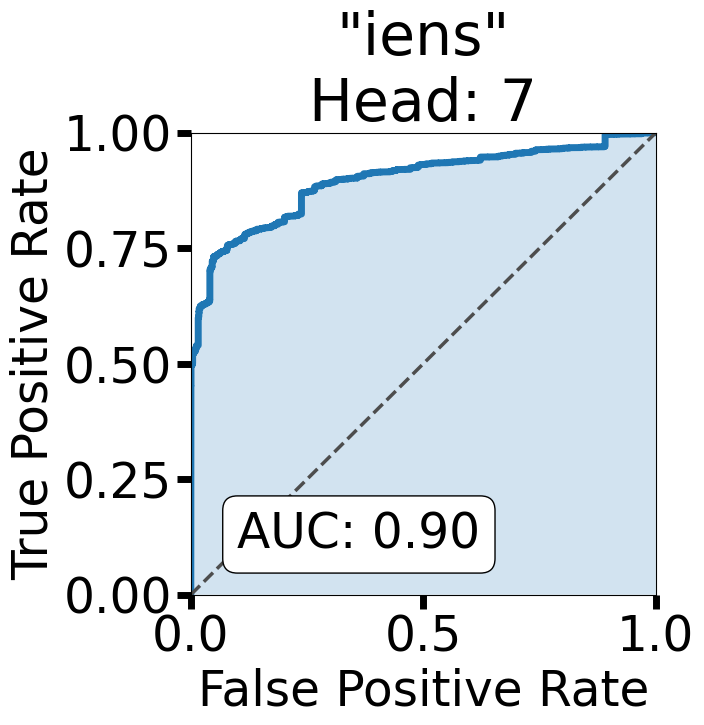

In [8]:
scale = 0.5
plt.rc("font", size=70 * scale)
plt.rcParams["axes.xmargin"] = 0.001
linewidth = 10 * scale

fpr, tpr, _ = roc_curve(y_true, y_score)
suffix = df_head["suffix_id"].to_numpy()[0]

fig, ax = plt.subplots(figsize=(12 * scale, 12 * scale))
ax.plot(
    fpr,
    tpr,
    linewidth=linewidth,
    # label=f"AUC: {recall_data['recall'].sum() / recall_data.height:.2f}",
)
ax.fill_between(
    fpr,
    tpr,
    linewidth=2,
    label=f"AUC: {roc_auc_score(y_true, y_score):.2f}",
    alpha=0.2,
)
ax.plot(
    [0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3", linewidth=linewidth * 0.5
)
ax.annotate(
    f"AUC: {roc_auc_score(y_true, y_score):.2f}",
    xy=(0.1, 0.1),
    bbox=dict(boxstyle="round", fc="w"),
)
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
# ax.legend(loc="lower right")
ax.set_title(f'"{data_retriever.tokenizer.decode(suffix)}"\nHead: {head}')
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.xaxis.set_tick_params(width=linewidth, length=linewidth * 2, direction="out")
ax.yaxis.set_tick_params(width=linewidth, length=linewidth * 2, direction="out")
# fig.savefig(f"recall_curve_{suffix}_{head}.png", dpi=300, bbox_inches="tight")